### importing required library 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings as w
w.filterwarnings('ignore')

### PARAMETERS

In [2]:
image_dir = "dataset"  # Directory with 1.jpg to 12.jpg
image_size = (128, 128)
num_classes = 6  # 6 construction stages

### LOAD IMAGES AND LABELS

In [5]:
images = []
labels = []

for i in range(1, 13):  # 1 to 12 images
    image_path = os.path.join(image_dir, f"{i}.jpg")
    image = load_img(image_path, target_size=image_size)
    image = img_to_array(image)
    image = preprocess_input(image)

    stage_label = (i - 1) // 2  # Two images per stage
    images.append(image)
    labels.append(stage_label)

images = np.array(images)
labels = to_categorical(labels, num_classes)

### TRAIN-TEST SPLIT

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### BUILD CNN MODEL USING MOBILENETV2

In [9]:
base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### TRAIN MODEL

In [10]:
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.1111 - loss: 2.6347 - val_accuracy: 0.0000e+00 - val_loss: 2.1250
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5556 - loss: 1.3063 - val_accuracy: 0.0000e+00 - val_loss: 2.0541
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 1.0000 - loss: 0.5616 - val_accuracy: 0.0000e+00 - val_loss: 1.9876
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.2771 - val_accuracy: 0.0000e+00 - val_loss: 1.9667
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 1.0000 - loss: 0.1570 - val_accuracy: 0.0000e+00 - val_loss: 1.9599
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 1.0000 - loss: 0.0888 - val_accuracy: 0.0000e+00 - val_loss: 1.9565
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 1.0000 - loss: 0.0496 - val_accuracy: 0.0000e+00 - val_loss: 1.9483
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - accuracy: 1.0000 - loss: 0.0282 - val_accu

### SAVE MODEL

In [11]:
model.save("stage_classifier_6stages.h5")

### PREDICT FUNCTION WITH DESCRIPTIONS

In [12]:
def predict_stage(image_path):
    stage_names = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5', 'Stage 6']
    stage_descriptions = [
        "🟡 Work Done: 0% – 16.6%\nInitial groundwork and layout have started. Excavation, boundary layout, and basic site prep are in progress.",
        "🟡 Work Done: 16.7% – 33.3%\nFoundation work is largely complete. Reinforcement, plinth beams, and initial columns are being built.",
        "🟡 Work Done: 33.4% – 50%\nGround floor structure completed. First floor columns and slab work underway. Significant structural progress visible.",
        "🟢 Work Done: 50.1% – 66.6%\nSuperstructure nearing completion. All floors erected, roofing and external frame taking shape.",
        "🟢 Work Done: 66.7% – 83.3%\nExterior finishing started. Electrical conduit, plastering, and preliminary painting in progress.",
        "✅ Work Done: 83.4% – 100%\nConstruction complete or near completion. Interior work, final paint, and finishing touches are being done."
    ]

    # Load and preprocess input image
    input_img = load_img(image_path, target_size=image_size)
    input_arr = img_to_array(input_img)
    preprocessed_img = preprocess_input(input_arr)
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

    # Predict the stage
    predictions = model.predict(preprocessed_img)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    # Print stage info
    print(f"\n🧠 Predicted Stage: {stage_names[predicted_class]}")
    print(f"📊 Confidence: {confidence:.2f}%")
    print(f"\n📋 Description:\n{stage_descriptions[predicted_class]}\n")

    # Show matched reference image
    match_img_index = predicted_class * 2 + 1  # Pick first image of the matched stage
    matched_img_path = os.path.join(image_dir, f"{match_img_index}.jpg")
    matched_img = load_img(matched_img_path, target_size=image_size)

    # Plot input and matched reference
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_arr.astype('uint8'))
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(matched_img)
    axs[1].set_title(f"Matched: {stage_names[predicted_class]}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

### EXAMPLE USAGE

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🧠 Predicted Stage: Stage 4
📊 Confidence: 99.98%

📋 Description:
🟢 Work Done: 50.1% – 66.6%
Superstructure nearing completion. All floors erected, roofing and external frame taking shape.



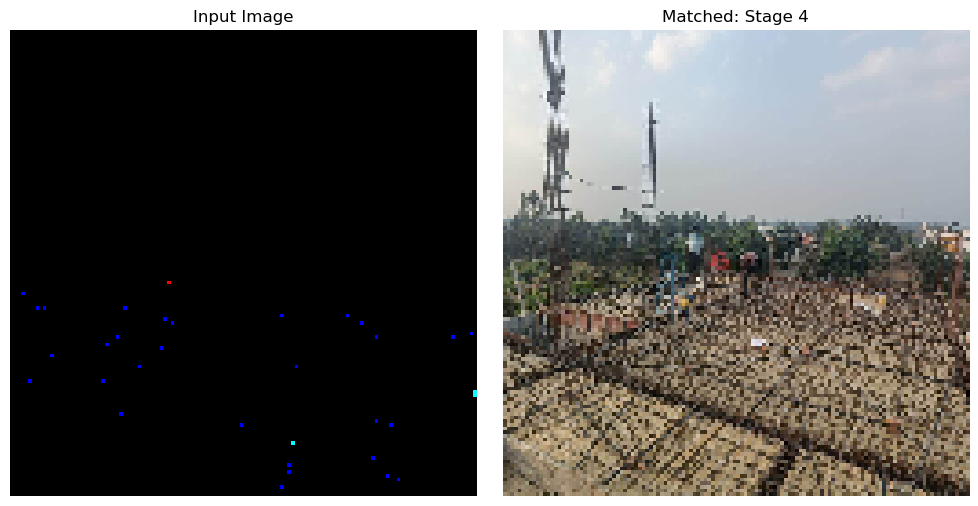

In [99]:
predict_stage("7.jpg")

In [10]:
import tensorflow as s

In [12]:
print(s.__version__)

2.18.0
